In [1]:
import os

#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from torch import nn
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding,DistilBertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

from transformers import DataCollatorForTokenClassification
import torch
from torch.autograd import Variable
from pathlib import Path
import re
from datasets import load_dataset

from sklearn.model_selection import train_test_split

import time
import wandb

from matplotlib import pyplot as plt

comet_ml is installed but `COMET_API_KEY` is not set.


In [2]:
df = pd.read_excel('DataML3.xlsx')

In [4]:
df[['ConsumerFactor','DEFECT_DESC','QHC_FUP_SERVICE_TYPE','OverallSatisfactionScore']].to_csv('DataML3.csv')

              label
count  36003.000000
mean       0.946645
std        0.157922
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


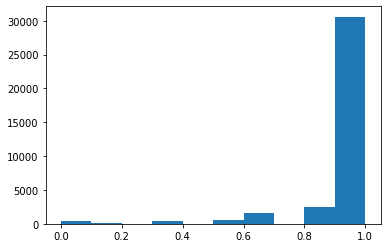

In [40]:
data=pd.read_csv('data.csv')
print(data.describe())
plt.hist(data['label'])
plt.show()

In [41]:
data=pd.read_csv('data.csv')
classes=np.sort(data['label'].drop_duplicates().values)
classes_dict={}
for i,cls in enumerate(classes):
    classes_dict[str(cls)]=i
print(len(classes_dict))
data['label']=data['label'].map(lambda x: classes_dict[str(x)])

max_len=[len(line.split(' ')) for line in data['text']]
print(max(max_len))
data.head(5)

9
80


,label,text
0,8,Нет изображения на дисплее
1,7,недостаточное замораживание в морозильной камере
2,8,не работает верхний вентилятор
3,8,Отключается
4,8,Дисплей/ нет изображения/ постоянно


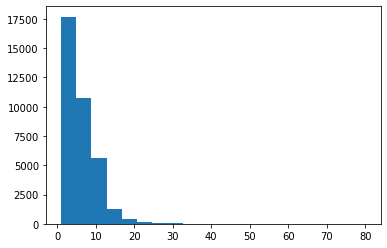

In [42]:
plt.hist(max_len,bins=20)
plt.show()

In [43]:
id2label = {str(i):label for i, label in enumerate(classes)}
label2id = {label:str(i) for i, label in enumerate(classes)}

In [44]:
dataset = Dataset.from_pandas(data,preserve_index=False)
dataset = dataset.train_test_split(test_size=0.2)

In [30]:
# model_name='sberbank-ai/ruBert-base'
model_name='distilbert-base-multilingual-cased'
# model_name='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name,model_max_length=32)

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9)
model.config.id2label = id2label
model.config.label2id = label2id
model.config._num_labels = len(id2label)
model.config.num_labels = len(id2label)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifie

In [45]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/29 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [33]:
tokenized_datasets['train'][0]

{'label': 8,
 'text': 'Не работае левый наушник.',
 'input_ids': [101,
  21124,
  27566,
  10205,
  94693,
  50941,
  10122,
  38368,
  11718,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [104]:
class DistilBertForMultilabelSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.criterion = torch.nn.BCEWithLogitsLoss()

    def forward(self,
                input_ids=None,
                attention_mask=None,
                head_mask=None,
                inputs_embeds=None,
                labels=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=None):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.distilbert(input_ids,
                                  attention_mask=attention_mask,
                                  head_mask=head_mask,
                                  inputs_embeds=inputs_embeds,
                                  output_attentions=output_attentions,
                                  output_hidden_states=output_hidden_states,
                                  return_dict=return_dict)

        hidden_state = outputs[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)


        loss_fct = torch.nn.BCEWithLogitsLoss()
        _, pred = torch.max(logits, 1)

        # print(logits)
        # print(pred)
        # print(labels)
        # loss = loss_fct(logits.view(-1, self.num_labels), labels.float().view(-1, self.num_labels))
        loss = loss_fct(pred.float(), labels.float())
        # print(loss)

        loss = Variable(loss, requires_grad = True)

        # loss = self.criterion(logits.unsqueeze(1).float(), labels.float()).to('cuda')


        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
                                        logits=logits,
                                        hidden_states=outputs.hidden_states,
                                        attentions=outputs.attentions)

In [105]:
num_labels=9
model_ckpt='distilbert-base-multilingual-cased'
model = DistilBertForMultilabelSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to('cuda')
model.config.id2label = id2label
model.config.label2id = label2id
model.config._num_labels = len(id2label)
model.config.num_labels = len(id2label)

loading configuration file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/config.json from cache at C:\Users\Администратор/.cache\huggingface\transformers\cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_la

In [50]:
metric = load_metric("seqeval")

def compute_metrics(input_data):
    true_predictions, true_labels = input_data
    # predictions = np.argmax(predictions, axis=2)
    #
    # true_predictions = [[p for (p, l) in zip(prediction, label) if l != -100] for prediction, label in
    #                     zip(predictions, labels)]
    # true_labels = [[l for (p, l) in zip(prediction, label) if l != -100] for prediction, label in
    #                zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    # print(results)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"]}

In [ ]:
# metric = load_metric("accuracy")
metric = load_metric("seqeval")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # if task != "stsb":
    predictions = np.argmax(predictions, axis=1)
    # else:
    # predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [106]:
batch_size=16
epochs=4

args = TrainingArguments(
    f"test-classify-{str(time.time())}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    learning_rate=1e-3,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    logging_strategy='steps',
    logging_first_step=True,
    logging_steps=5,
    report_to='wandb',
    # fp16=True,
    weight_decay=1e-5,
    dataloader_num_workers=4,
    metric_for_best_model='accuracy'
)

# args = TrainingArguments(
#     f"test-classify-{str(time.time())}",
#     evaluation_strategy="epoch",
#     learning_rate=1e-3,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=epochs,
#     logging_steps=10,
#     weight_decay=1e-2,
#     report_to='wandb'
# )





data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    # data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices


In [56]:
wandb.finish()

In [107]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForMultilabelSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 28802
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7204
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMultilabelSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 7201
  Batch size = 16


TypeError: object of type 'numpy.int64' has no len()

In [ ]:
trainer.evaluate(tokenized_datasets['test'])

In [ ]:
model.save_pretrained("mazur")
tokenizer.save_pretrained("mazur")

In [ ]:
# load the model/tokenizer
from transformers import AutoModelForTokenClassification
model = AutoModelForSequenceClassification.from_pretrained("model")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:

trainer = Trainer(model=model)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
def pipeline_prediction(text):
    df=pd.DataFrame({'text':[text]})
    dataset = Dataset.from_pandas(df,preserve_index=False)
    tokenized_datasets = dataset.map(tokenize_function)
    raw_pred, _, _ = trainer.predict(tokenized_datasets)
    return(raw_pred[0][0])